In [27]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import os
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader
import cv2
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

data_dir = '/content/drive/MyDrive/Project_dataset'


In [ ]:

def preprocess_hindi_image(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    edges = cv2.Canny(binary, 50, 100, apertureSize=5)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=70, minLineLength=70, maxLineGap=15)

    if lines is not None:
        longest_line = None
        max_length = 0
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            if abs(y1 - y2) < 10 and length > max_length:
                max_length = length
                longest_line = (x1, y1, x2, y2)
        rotated = binary if longest_line is None else binary
    else:
        rotated = binary

    kernel = np.ones((3, 3), np.uint8)
    processed = cv2.morphologyEx(rotated, cv2.MORPH_CLOSE, kernel)
    erosion_kernel = np.ones((2, 2), np.uint8)
    thinned = cv2.erode(processed, erosion_kernel, iterations=1)
    final_image = cv2.resize(thinned, (128, 128))  # Resize to 128x128
    return final_image

def skeletonize_image(image):
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    skeleton = np.zeros_like(binary)
    element = np.ones((3, 3), np.uint8)
    while True:
        temp = cv2.morphologyEx(binary, cv2.MORPH_OPEN, element)
        temp = cv2.subtract(binary, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        binary = cv2.erode(binary, element)
        if cv2.countNonZero(binary) == 0:
            break
    kernel = np.ones((3, 3), np.uint8)
    skeleton_closed = cv2.morphologyEx(skeleton, cv2.MORPH_CLOSE, kernel)
    return skeleton_closed


In [ ]:

class CustomPreprocessedDataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.labels = pd.read_csv(labels_file, header=None, names=['image', 'label'], sep='\t')
        self.image_paths = self.labels['image'].apply(lambda x: x.strip()).tolist()
        self.labels = self.labels['label'].apply(lambda x: x.strip()).tolist()
        self.classes = sorted(list(set(self.labels)))  # Unique sorted classes

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        img_path = os.path.join(self.img_dir, self.image_paths[idx])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")


        processed_image = preprocess_hindi_image(image)
        skeletonized_image = skeletonize_image(processed_image)


        skeletonized_image = Image.fromarray(skeletonized_image)


        if self.transform:
            skeletonized_image = self.transform(skeletonized_image)

        # Return the processed image and its label
        label = self.classes.index(self.labels[idx])
        return skeletonized_image, label




train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



train_dir = '/content/drive/MyDrive/Project_dataset/train'
test_dir = '/content/drive/MyDrive/Project_dataset/val'
labels_file = '/content/drive/MyDrive/Project_dataset/val/labels.txt'


test_images = os.listdir(test_dir)
print("Test images in the directory:", test_images[:10])


train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = CustomPreprocessedDataset(test_dir, labels_file, transform=test_transform)


print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(f"Example data shape: {example_data.shape}")

Test images in the directory: ['70.jpg', '113.jpg', '141.jpg', '117.jpg', '32 (1).jpg', '140.jpg', '45.jpg', '122.jpg', '33.jpg', '32.jpg']
Num training images:  1000
Num test images:  200
Example data shape: torch.Size([32, 1, 128, 128])


In [29]:
classes = os.listdir(train_dir)
print(len(classes))
classes

25


['लॉ',
 'छः',
 'ई',
 'बृ',
 'खु',
 'ण',
 'माँ',
 'क़ै',
 'गो',
 'पं',
 'हाँ',
 'झं',
 'टी',
 'ढ़ी',
 'रौ',
 'ऋ',
 'सृ',
 'षु',
 'ञ',
 'चा',
 'वैं',
 'धौ',
 'ने',
 'जा',
 'फ़']

In [30]:
batch_size = 32
valid_size = 0.10

num_train = len(train_data)
split_point = int(valid_size * num_train)

indices = list(range(num_train))
np.random.shuffle(indices)

valid_indices = indices[:split_point]
train_indices = indices[split_point:]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [31]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [32]:
# checking batch
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([32, 3, 32, 32])

In [33]:
# checking batch
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([32, 1, 128, 128])

In [34]:
torch.cuda.is_available()

True

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2330 (\N{DEVANAGARI LETTER CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

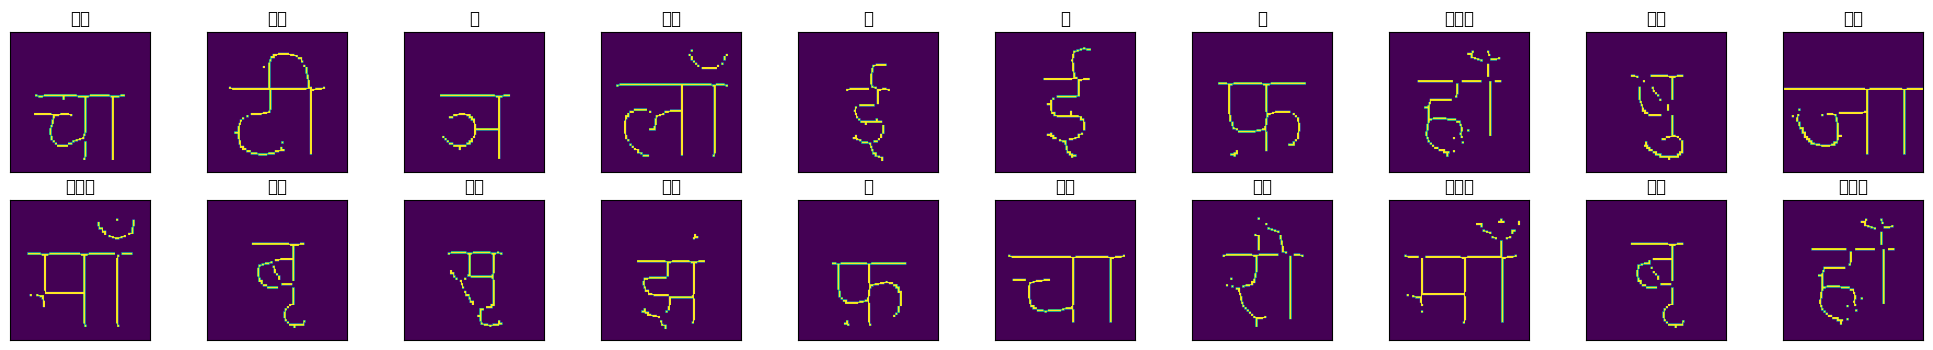

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2331 (\N{DEVANAGARI LETTER CHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2307 (\N{DEVANAGARI SIGN VISARGA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


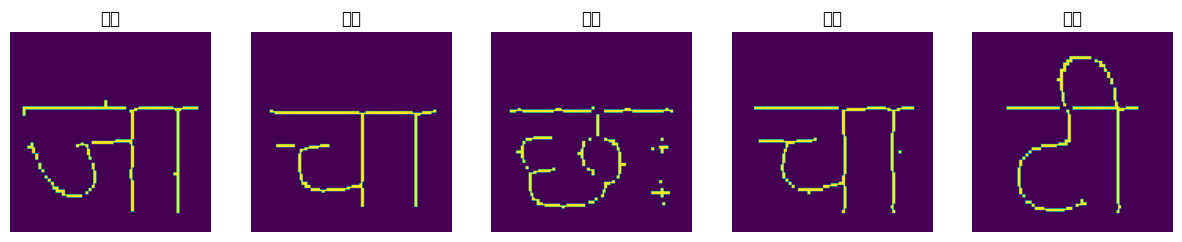

In [ ]:

train_on_gpu = torch.cuda.is_available()


dataiter = iter(test_loader)
images, labels = next(dataiter)  


if train_on_gpu:
    images = images.cuda()


fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])


    img = images.cpu()[idx]
    img = img * 0.5 + 0.5  
    img = np.transpose(img, (1, 2, 0))  

    plt.imshow(img) 



    label_index = labels[idx].item() if isinstance(labels[idx], torch.Tensor) else labels[idx]


    ax.set_title(test_data.classes[label_index])



fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for idx, ax in enumerate(axes):
    ax.imshow(example_data[idx].permute(1, 2, 0))  
    ax.axis('off')


    label_index = example_targets[idx].item()  
    ax.set_title(test_data.classes[label_index])  

plt.show()


# CNN

In [36]:
def output(input_volume, kernel_size, padding, stride=1):
    return ((input_volume - kernel_size + 2 * padding)/stride) + 1

input_size = 32
print("Input image is of size: {}x{}".format(input_size, input_size))
print("First Conv sees: {}x{}".format(input_size, input_size))
input_size = output(input_volume=input_size, kernel_size=5, padding=0, stride=1)
print("Second Conv sees: {}x{}".format(input_size, input_size))
input_size = output(input_volume=input_size, kernel_size=5, padding=0, stride=1)
print("Third Conv sees: {}x{}".format(input_size, input_size))
input_size = output(input_volume=input_size, kernel_size=5, padding=0, stride=1)
print("Fourth Conv sees: {}x{}".format(input_size, input_size))

Input image is of size: 32x32
First Conv sees: 32x32
Second Conv sees: 28.0x28.0
Third Conv sees: 24.0x24.0
Fourth Conv sees: 20.0x20.0


In [ ]:


class Network(nn.Module):
    def __init__(self):
        super().__init__()


        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,
                               kernel_size=5, stride=1, padding=0)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,
                               kernel_size=5, stride=1, padding=0)  


        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=3, stride=1, padding=0)  



        self.fc1 = nn.Linear(3 * 3 * 64, 1000)
        self.fc2 = nn.Linear(1000, 46)  
        self.dropout = nn.Dropout(p=0.15)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))


        x = x.view(x.size(0), -1)  


        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [38]:
train_on_gpu = True if torch.cuda.is_available() else False
train_on_gpu

True

In [39]:
dhcd_model = Network()

if train_on_gpu:
  print("Training on GPU...")
  dhcd_model.cuda()



Training on GPU...


In [48]:
best_model_path = "/content/drive/MyDrive/Project_dataset/model_heresToHoping.pt"

if os.path.exists(best_model_path):
    print(f"Loading best model weights from {best_model_path}")
    dhcd_model.load_state_dict(torch.load(best_model_path))

Loading best model weights from /content/drive/MyDrive/Project_dataset/model_heresToHoping.pt


<ipython-input-48-81d2cb57e946>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dhcd_model.load_state_dict(torch.load(best_model_path))


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dhcd_model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
n_epochs = 1000
train_losses = []
valid_losses = []
valid_loss_min = np.inf
train_accuracies = []
valid_accuracies = []

# Metrics tracked
metrics = {
    "train_losses": train_losses,
    "valid_losses": valid_losses,
    "train_accuracies": train_accuracies,
    "valid_accuracies": valid_accuracies,
    "valid_loss_min": valid_loss_min
}

for e in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0

    # Training phase
    dhcd_model.train()

    for img, label in train_loader:
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        predicted_label = dhcd_model(img)
        loss = criterion(predicted_label, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


        _, predicted = predicted_label.topk(1, dim=1)
        train_total += label.size(0)
        train_correct += (predicted == label.view(*predicted.shape)).sum().item()


    dhcd_model.eval()

    for img, label in valid_loader:
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        predicted_label = dhcd_model(img)
        loss = criterion(predicted_label, label)
        valid_loss += loss.item()


        _, predicted = predicted_label.topk(1, dim=1)
        valid_total += label.size(0)
        valid_correct += (predicted == label.view(*predicted.shape)).sum().item()


    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    train_accuracy = (train_correct / train_total) * 100
    valid_accuracy = (valid_correct / valid_total) * 100


    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)


    print(f"Epoch: {e + 1}/{n_epochs} "
          f"Train Loss: {train_loss:.3f}.. "
          f"Train Accuracy: {train_accuracy:.2f}%.. "
          f"Validation Loss: {valid_loss:.3f}.. "
          f"Validation Accuracy: {valid_accuracy:.2f}%")


    if valid_loss < valid_loss_min:
        print(f"Validation Loss Decreased From {valid_loss_min:.6f} to {valid_loss:.6f}")
        valid_loss_min = valid_loss
        torch.save(dhcd_model.state_dict(), "dhcd_model_1.pth")
        print("Saving Best Model")


print("\nMetrics Tracked:")
print(f"Train Losses: {metrics['train_losses']}")
print(f"Validation Losses: {metrics['valid_losses']}")
print(f"Train Accuracies: {metrics['train_accuracies']}")
print(f"Validation Accuracies: {metrics['valid_accuracies']}")
print(f"Minimum Validation Loss: {metrics['valid_loss_min']}")


Epoch: 1/500 Train Loss: 1.372.. Train Accuracy: 55.44%.. Validation Loss: 0.878.. Validation Accuracy: 62.00%
Validation Loss Decreased From inf to 0.878051
Saving Best Model
Epoch: 2/500 Train Loss: 1.290.. Train Accuracy: 59.33%.. Validation Loss: 1.332.. Validation Accuracy: 63.00%
Epoch: 3/500 Train Loss: 1.251.. Train Accuracy: 59.67%.. Validation Loss: 1.018.. Validation Accuracy: 69.00%
Epoch: 4/500 Train Loss: 1.232.. Train Accuracy: 60.22%.. Validation Loss: 1.071.. Validation Accuracy: 70.00%
Epoch: 5/500 Train Loss: 1.289.. Train Accuracy: 59.22%.. Validation Loss: 1.047.. Validation Accuracy: 63.00%
Epoch: 6/500 Train Loss: 1.244.. Train Accuracy: 58.56%.. Validation Loss: 0.984.. Validation Accuracy: 59.00%
Epoch: 7/500 Train Loss: 1.279.. Train Accuracy: 56.78%.. Validation Loss: 1.005.. Validation Accuracy: 66.00%
Epoch: 8/500 Train Loss: 1.175.. Train Accuracy: 61.89%.. Validation Loss: 1.254.. Validation Accuracy: 62.00%
Epoch: 9/500 Train Loss: 1.179.. Train Accuracy

In [23]:
torch.save(dhcd_model.state_dict(), "/content/drive/MyDrive/Project_dataset/model_heresToHoping.pt")

In [45]:
dhcd_model.load_state_dict(torch.load("dhcd_model_1.pth"))


<ipython-input-45-654dd6eebd6c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dhcd_model.load_state_dict(torch.load("dhcd_model_1.pth"))


<All keys matched successfully>

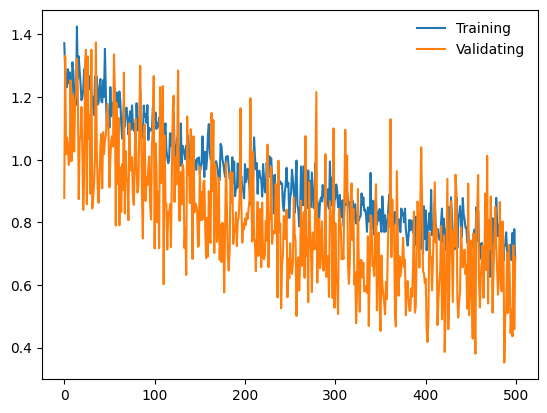

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(train_losses, label="Training")
axes.plot(valid_losses, label="Validating")
axes.legend(frameon=False)

In [47]:
print('train : ')
print(train_losses)
print('val : ')
print(valid_losses)

train : 
[1.3721465817813217, 1.2904013415862774, 1.2508208916105072, 1.2315821154364224, 1.2890848764057816, 1.2443901300430298, 1.279165740670829, 1.1752546388527443, 1.1791162978986214, 1.3115506110520199, 1.2819400039212456, 1.214155994612595, 1.194302733602195, 1.174895786005875, 1.4254989993983302, 1.2577394329268357, 1.3303163812078278, 1.2841789742995953, 1.2458324144626487, 1.1901362219761158, 1.199176500583517, 1.22297930511935, 1.288895056165498, 1.204520831848013, 1.1374660339848748, 1.2359556987367828, 1.2005767226219177, 1.265063883929417, 1.2249583375865016, 1.2681885649418008, 1.2122456030599003, 1.1672288405484166, 1.2008916201262638, 1.142765345244572, 1.2654799264052818, 1.218576007875903, 1.2649012454624833, 1.1758527694077328, 1.1834914889828911, 1.2335938636598915, 1.2578199608572598, 1.1867185358343453, 1.1835217475891113, 1.2536576390266418, 1.200251194937476, 1.3541057109832764, 1.2143858794508309, 1.1048510907025173, 1.1027632437903305, 1.1613209864188885, 1.1